In [1]:
!pip install keras-tuner



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [4]:

from dotenv import load_dotenv
import os

load_dotenv()
username = "AnshSG13"
api_key = os.getenv("API_KEY")
repo = "soccer_sports_betting"



In [ ]:
!rm -rf /content/drive/My\ Drive/GitHub/soccer_sports_betting

In [5]:
!git clone https://{token}@github.com/{username}/soccer_sports_betting.git

Cloning into 'soccer_sports_betting'...
remote: Repository not found.
fatal: repository 'https://github.com/{username}/soccer_sports_betting.git/' not found


In [ ]:
%ls

soccer_sports_betting/  soccer_sports_betting_old/


In [ ]:
import os
print(os.getcwd())

/content/drive/MyDrive/machine_learning


In [ ]:
cd sports_betting

/content/drive/MyDrive/machine_learning/sports_betting


In [ ]:
directory = 'drive/MyDrive/machine_learning' # Replace with working directory

%cd $directory

[Errno 2] No such file or directory: 'drive/MyDrive/machine_learning'
/content/drive/MyDrive/machine_learning/soccer_sports_betting/code


## Load Data

Assign a data point to each game (two columns per stat, one for the home and one for the away team)

Use data only **up to** that matchweek

## Data Preprocessing
Create a data point for each match, with the stats of the home and away team. Our labels are the match outcomes, where 0 = Home, 1 = Draw, and 2 = Away.



In [7]:
# Cell 1: Data Processing (retain HomeTeam/AwayTeam for embeddings/IDs)

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1) Load match data
def load_match_data(years, path_template='outcomes/{}.csv'):
    frames = []
    for year in years:
        df = pd.read_csv(
            path_template.format(year),
            usecols=['HomeTeam','AwayTeam','Date','FTR','B365H','B365D','B365A']
        )
        df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
        df = df.rename(columns={
            'B365H': 'odds_home_win',
            'B365D': 'odds_draw',
            'B365A': 'odds_away_win'
        })
        df['outcome'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

years      = ['2018','2019','2020','2021','2022','2023']
match_data = load_match_data(years)

# 2) Load weekly stats snapshots
week_data, dates = {}, []
for year in years:
    for file in os.scandir(f'data/{year}'):
        if not file.is_file():
            continue
        snap_date = pd.to_datetime(file.name.split('_')[2].split('.')[0])
        df_stats  = pd.read_csv(file.path, index_col=0)

        week_data[snap_date] = df_stats
        dates.append(snap_date)
dates = sorted(set(dates))

def prev_snapshot(game_date):
    """Return latest snapshot date strictly before game_date."""
    for i, d in enumerate(dates):
        if game_date < d:
            return dates[i-1] if i else dates[0]
    return dates[-1]



FileNotFoundError: [Errno 2] No such file or directory: 'outcomes/2018.csv'

In [ ]:
print(dates[0])

2018-08-10 00:00:00


In [ ]:
date_key = pd.to_datetime('2018-08-10 00:00:00')
print(week_data[date_key])

                            homeAttackAdvantage  homeDefenceAdvantage  \
Arsenal FC                                    0                     0   
Tottenham Hotspur FC                          0                     0   
Manchester City FC                            0                     0   
Leicester City FC                             0                     0   
Crystal Palace FC                             0                     0   
Everton FC                                    0                     0   
Burnley FC                                    0                     0   
Southampton FC                                0                     0   
AFC Bournemouth                               0                     0   
Manchester United FC                          0                     0   
Liverpool FC                                  0                     0   
Chelsea FC                                    0                     0   
West Ham United FC                            0    

In [ ]:
print(week_data.keys())

dict_keys([Timestamp('2019-02-02 00:00:00'), Timestamp('2019-03-02 00:00:00'), Timestamp('2019-05-12 00:00:00'), Timestamp('2019-03-30 00:00:00'), Timestamp('2019-05-04 00:00:00'), Timestamp('2018-12-21 00:00:00'), Timestamp('2018-10-19 00:00:00'), Timestamp('2019-04-27 00:00:00'), Timestamp('2019-04-02 00:00:00'), Timestamp('2018-12-04 00:00:00'), Timestamp('2019-04-20 00:00:00'), Timestamp('2019-03-09 00:00:00'), Timestamp('2019-04-13 00:00:00'), Timestamp('2018-10-26 00:00:00'), Timestamp('2018-10-05 00:00:00'), Timestamp('2019-04-06 00:00:00'), Timestamp('2018-12-15 00:00:00'), Timestamp('2018-12-08 00:00:00'), Timestamp('2019-01-12 00:00:00'), Timestamp('2019-02-09 00:00:00'), Timestamp('2018-08-17 00:00:00'), Timestamp('2018-08-24 00:00:00'), Timestamp('2018-11-24 00:00:00'), Timestamp('2019-02-22 00:00:00'), Timestamp('2018-08-31 00:00:00'), Timestamp('2019-01-29 00:00:00'), Timestamp('2018-11-03 00:00:00'), Timestamp('2018-09-28 00:00:00'), Timestamp('2018-11-10 00:00:00'), Tim

In [ ]:
# 3) Build feature rows (now preserving HomeTeam/AwayTeam)
rows = []
for _, row in match_data.iterrows():
    gdate  = row['Date']
    snap   = prev_snapshot(gdate)
    home_f = week_data[snap].loc[row['HomeTeam']].add_suffix('_home')
    away_f = week_data[snap].loc[row['AwayTeam']].add_suffix('_away')
    odds_f = row[['odds_home_win','odds_draw','odds_away_win']]

    feats = pd.concat([home_f, away_f, odds_f])
    feats['HomeTeam'] = row['HomeTeam']
    feats['AwayTeam'] = row['AwayTeam']

    feats['outcome']   = row['outcome']
    feats['game_date'] = gdate

    rows.append(feats)

full_df = pd.DataFrame(rows).sort_values('game_date').reset_index(drop=True)

In [ ]:
full_df.to_csv('soccer_data.csv', index=True)

In [ ]:
print(full_df.head())

   homeAttackAdvantage_home  homeDefenceAdvantage_home  \
0                       0.0                        0.0   
1                       0.0                        0.0   
2                       0.0                        0.0   
3                       0.0                        0.0   
4                       0.0                        0.0   

   homeOverallAdvantage_home  seasonGoals_overall_home  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        0.0                       0.0   
4                        0.0                       0.0   

   seasonConceded_overall_home  seasonGoalsTotal_overall_home  \
0                          0.0                            0.0   
1                          0.0                            0.0   
2                          0.0                            0.0   
3                          0.0            

In [ ]:


# -----------------------------------------------
# Elo feature engineering
# -----------------------------------------------
from collections import defaultdict
import numpy as np

def compute_elo_features(df: pd.DataFrame,
                         team_col_home: str = "home_id",
                         team_col_away: str = "away_id",
                         outcome_col: str   = "outcome",
                         base_elo: float    = 1500.0,
                         K: float           = 30.0,
                         home_adv: float    = 65.0,   # ~65 Elo ≈ 0.60 win prob
                         use_goal_diff: bool = False,
                         gd_scaler: float   = 30.0):
    """
    Adds 'elo_home' and 'elo_away' columns that contain each team's rating
    *before* the match is played, then updates ratings in‑place.

    Parameters
    ----------
    base_elo : float
        Starting rating for a brand‑new team.
    K : float
        Elo learning‑rate factor.
    home_adv : float
        Elo points added to the home side when computing expectations.
        Set to 0 to disable.
    use_goal_diff : bool
        If True, scale K by (1 + (goal_diff / gd_scaler)).
        Requires a 'FTR' or goal‑columns to infer goal difference; otherwise leave False.
    """
    df = df.sort_values("game_date").copy()           # make sure we go oldest→newest
    ratings = defaultdict(lambda: base_elo)           # dynamic dict of team ratings

    elo_h_list, elo_a_list = [], []

    for idx, row in df.iterrows():
        h_id, a_id = row[team_col_home], row[team_col_away]
        R_h, R_a   = ratings[h_id], ratings[a_id]

        # ----- record current ratings as features -----
        elo_h_list.append(R_h)
        elo_a_list.append(R_a)

        # ----- expectation with optional home advantage -----
        R_h_eff = R_h + home_adv
        exp_h   = 1.0 / (1.0 + 10 ** ((R_a - R_h_eff) / 400))
        exp_a   = 1.0 - exp_h

        # ----- actual score -----
        if   row[outcome_col] == 0:   # home win
            S_h, S_a = 1.0, 0.0
            goal_diff = 1            # if you have row['FTHG'] - row['FTAG'] use it
        elif row[outcome_col] == 1:   # draw
            S_h, S_a = 0.5, 0.5
            goal_diff = 0
        else:                         # away win
            S_h, S_a = 0.0, 1.0
            goal_diff = 1

        # optional goal‑difference scaling
        K_eff = K
        if use_goal_diff:
            K_eff = K * (1 + goal_diff / gd_scaler)

        # ----- update ratings -----
        ratings[h_id] += K_eff * (S_h - exp_h)
        ratings[a_id] += K_eff * (S_a - exp_a)

    # attach to df
    df["elo_home"] = elo_h_list
    df["elo_away"] = elo_a_list
    return df

teams = sorted(set(full_df['HomeTeam']) | set(full_df['AwayTeam']))
team_to_id = {t:i for i,t in enumerate(teams)}
full_df['home_id'] = full_df['HomeTeam'].map(team_to_id)
full_df['away_id'] = full_df['AwayTeam'].map(team_to_id)

full_df = compute_elo_features(full_df,
                               base_elo=1500,
                               K=30,
                               home_adv=65,
                               use_goal_diff=False)   # toggle if you have goal diff








Elo features added — new feature count: 30


In [ ]:
# 4-a) Count each team’s total matches (home+away)
all_teams = pd.concat([
    full_df['HomeTeam'],
    full_df['AwayTeam']
], axis=0)

team_counts = all_teams.value_counts().sort_index()  # by team name

# 4-b) Print each team and its frequency
print("Team\t#Matches")
for team, count in team_counts.items():
    print(f"{team}\t{count}")


Team	#Matches
AFC Bournemouth	152
Arsenal FC	228
Aston Villa FC	190
Brentford FC	114
Brighton & Hove Albion FC	228
Burnley FC	190
Cardiff City FC	38
Chelsea FC	228
Crystal Palace FC	228
Everton FC	228
Fulham FC	152
Huddersfield Town FC	38
Leeds United FC	114
Leicester City FC	190
Liverpool FC	228
Luton Town FC	38
Manchester City FC	228
Manchester United FC	228
Newcastle United FC	228
Norwich City FC	76
Nottingham Forest FC	76
Sheffield United FC	114
Southampton FC	190
Tottenham Hotspur FC	228
Watford FC	114
West Bromwich Albion FC	38
West Ham United FC	228
Wolverhampton Wanderers FC	228


##Feature Selection

In [ ]:
import os
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats
from scipy.cluster import hierarchy as sch
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest, f_classif,
    SelectFromModel
)
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------------------
# 0) Configuration & Utilities
# ---------------------------------------
plt.rcParams.update({"figure.dpi": 120, "axes.grid": False})
OUTPUT_DIR = "feature_selection_report"
os.makedirs(OUTPUT_DIR, exist_ok=True)
SEED = 42
np.random.seed(SEED)

def mirror_columns(X_train, X_test, missing_thresh: float = 0.5):
    """Drop columns with too much missingness."""
    good = X_train.columns[X_train.isnull().mean() < missing_thresh]
    return X_train[good].copy(), X_test[good].copy()

def _fix_ticks(ax, labels, axis="x", fontsize=6):
    """Fix tick formatting for heatmaps."""
    pos = np.arange(len(labels)) + 0.5
    locator = FixedLocator(pos)
    formatter = FixedFormatter(labels)
    if axis == "x":
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(90); lbl.set_fontsize(fontsize)
    else:
        ax.yaxis.set_major_locator(locator)
        ax.yaxis.set_major_formatter(formatter)
        for lbl in ax.get_yticklabels():
            lbl.set_rotation(0); lbl.set_fontsize(fontsize)

def plot_corr_heatmap(df, method, title, fname):
    """Save a correlation heatmap."""
    corr = df.corr(method=method)
    fig, ax = plt.subplots(figsize=(12,10))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, ax=ax)
    _fix_ticks(ax, corr.columns.tolist(), "x")
    _fix_ticks(ax, corr.columns.tolist(), "y")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, fname), dpi=150, bbox_inches="tight")
    plt.close()

# ---------------------------------------
# 1) Pipeline Construction
# ---------------------------------------
def build_pipeline(k_best: int = 1000,
                   pca_var: float | None = None):
    steps = [
        ("impute",     SimpleImputer(strategy="mean")),
        ("scale",      StandardScaler()),
        ("var_thresh", VarianceThreshold()),
        ("univariate", SelectKBest(f_classif, k=k_best)),
        ("enet_sel",   SelectFromModel(
            ElasticNetCV(
                l1_ratio=[.9], cv=3, max_iter=500,
                tol=1e-3, n_jobs=-1, random_state=SEED,
                verbose=0
            ),
            threshold=0.000001,
            max_features=80        # select top 80 by |coef|
        )),
    ]
    if pca_var:
        steps.append(("pca", PCA(n_components=pca_var, random_state=SEED)))
    return Pipeline(steps, verbose=True)

# ---------------------------------------
# 2) Fit & Track Feature Names
# ---------------------------------------
def fit_and_track(pipe: Pipeline, X: pd.DataFrame, y: pd.Series):
    """Fit pipeline and record surviving feature names at each step."""
    pipe.fit(X, y)
    names = {}
    X_tmp = X.copy()
    for name, step in pipe.named_steps.items():
        X_tmp = step.transform(X_tmp)
        if hasattr(step, "get_support"):
            prev = names[list(names)[-1]] if names else X.columns
            names[name] = prev[step.get_support()]
    return pipe, names

# ---------------------------------------
# 3) Extract ElasticNet Coefficients
# ---------------------------------------
def extract_enet_coefs(pipe, names):
    """Return pandas Series of the ElasticNet coefficients for selected features."""
    sel = pipe.named_steps["enet_sel"]
    enet = sel.estimator_
    # feature names after univariate selection
    univ_feats = names["univariate"]
    mask = sel.get_support()      # boolean mask over those univ_feats
    feats = univ_feats[mask]
    coefs = enet.coef_[mask]
    return pd.Series(coefs, index=feats).abs().sort_values(ascending=False)


feature_cols = [
    c for c in full_df.columns
    if c not in ("HomeTeam", "AwayTeam", "game_date", "outcome")
]

def main(X_train, X_test, y_train):
    # 1) Mirror train/test columns
    X_tr, X_te = mirror_columns(X_train, X_test)

    # 2) Fit pipeline and track feature names
    pipe, names = fit_and_track(build_pipeline(), X_tr, y_train)

    # 3) Extract and display ElasticNet coefficients
    coef_series = extract_enet_coefs(pipe, names)
    print("Top 80 ElasticNet feature coefficients:")
    print(coef_series)

    # 4) Print selected feature names as a NumPy array
    feature_array = coef_series.index.to_numpy()
    print("\nSelected feature names array:")
    print(feature_array)

    return pipe, names, coef_series

# -----------------------
# Example Usage
# -----------------------
train_mask = full_df['game_date'] < pd.Timestamp('2023-01-01')
X_train = full_df.loc[train_mask, feature_cols]
y_train = full_df.loc[train_mask, 'outcome']
X_test = full_df.loc[~train_mask, feature_cols]
pipe, names, coefs = main(X_train, X_test, y_train)




[Pipeline] ............ (step 1 of 5) Processing impute, total=   0.2s
[Pipeline] ............. (step 2 of 5) Processing scale, total=   0.2s
[Pipeline] ........ (step 3 of 5) Processing var_thresh, total=   0.2s
[Pipeline] ........ (step 4 of 5) Processing univariate, total=   0.2s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4540241868559178, tolerance: 0.865529830810329
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9407634136396155, tolerance: 0.865529830810329
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0725479344191626, tolerance: 0.8599402852049913
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergenc

[Pipeline] .......... (step 5 of 5) Processing enet_sel, total=  27.2s
Top 80 ElasticNet feature coefficients:
odds_home_win                                  0.149842
odds_away_win                                  0.114329
average_attendance_home_home                   0.039478
elo_home                                       0.030960
over45CornersAgainstPercentage_overall_away    0.027191
over45CornersAgainstPercentage_home_away       0.022600
over45CornersForPercentage_overall_away        0.020614
leaguePosition_away_home                       0.018469
leadingAtHTPercentage_away_home                0.016847
over25CornersAgainstPercentage_home_home       0.014082
over45OffsidesPercentage_home_home             0.009663
goals_scored_min_76_to_90_away_away            0.008949
seasonConcededMin_overall_away                 0.007321
scored_2hg_avg_overall_away                    0.006370
elo_away                                       0.006164
over75CornersFor_home_home                     0.

In [ ]:
inf_feats = vif_df[vif_df["VIF"] == np.inf]["Feature"].tolist()
print("Perfectly collinear features:", inf_feats)


Perfectly collinear features: ['gd_text_2hg_away_away', 'gd_2hg_away_away']


In [ ]:
selected_columns = [
    'odds_home_win',
    'odds_away_win',
    'average_attendance_home_home',
    'elo_home',
    'over45CornersAgainstPercentage_overall_away',
    'over45CornersAgainstPercentage_home_away',
    'over45CornersForPercentage_overall_away',
    'leaguePosition_away_home',
    'leadingAtHTPercentage_away_home',
    'over25CornersAgainstPercentage_home_home',
    'over45OffsidesPercentage_home_home',
    'goals_scored_min_76_to_90_away_away',
    'seasonConcededMin_overall_away',
    'scored_2hg_avg_overall_away',
    'elo_away',
    'over75CornersFor_home_home',
    'goals_scored_min_46_to_60_home_home',
    'seasonCSPercentage_home_away',
    'losePercentage_away_home',
    'winPercentage_home_away',
    'cornersAgainstAVG_home_home',
    'seasonConcededMin_away_away'
]


## Model Construction

In [ ]:
# Cell 2 (revised): Model Definition with Residual Connections
from keras import Input, Model
from keras.layers import Embedding, Flatten, Concatenate, Dense, BatchNormalization, LeakyReLU, Dropout, Add
from keras.optimizers import Adam
from keras.regularizers import l2

def build_model(
    n_feats: int,
    n_teams: int,
    emb_dim: int = 16,
    hidden_units: int = 64,
    dropout_rate: float = 0.4,
    l2_reg: float = 5e-2,
    lr: float = 1e-3,
) -> Model:
    """Return a compact Keras model for 3‑way outcome classification."""

    # ── numeric branch ──────────────────────────────────────────
    num_in = Input(shape=(n_feats,), name="numeric")

    # ── team embedding branch (shared) ─────────────────────────
    team_emb = Embedding(
        input_dim=n_teams,
        output_dim=emb_dim,
        embeddings_regularizer=l2(l2_reg),
        name="team_emb",
    )
    home_id = Input(shape=(1,), dtype="int32", name="home_id")
    away_id = Input(shape=(1,), dtype="int32", name="away_id")

    home_vec = Flatten()(team_emb(home_id))
    away_vec = Flatten()(team_emb(away_id))

    # ── concatenate all features ───────────────────────────────
    x = Concatenate(name="concat")([num_in, home_vec, away_vec])

    # ── small fully‑connected head ─────────────────────────────
    for _ in range(2):  # two hidden layers only
        x = Dense(hidden_units, kernel_initializer="he_uniform",
                  kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Dropout(dropout_rate)(x)
        hidden_units //= 2  # halve width for the second layer

    out = Dense(3, activation="softmax", name="pred")(x)

    model = Model(inputs=[num_in, home_id, away_id], outputs=out,
                  name="simple_match_predictor")

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

n_feats = len(selected_columns)
n_teams = max(full_df['home_id'].max(), full_df['away_id'].max()) + 1
base_model = build_model(n_feats, n_teams)

# Print model summary
base_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "simple_match_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ home_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_id             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ team_emb            │ (None, 1, 16)     │        448 │ home_id[0][0],    │
│ (Embedding)         │                   │            │ away_id[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_46          │ (None, 16)        │          0 │ team_emb[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_47          │ (None, 16)        │          0 │ team_emb[1][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 33)        │          0 │ numeric[0][0],    │
│ (Concatenate)       │                   │            │ flatten_46[0][0], │
│                     │                   │            │ flatten_47[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 64)        │      2,176 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_58[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_58      │ (None, 64)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 64)        │          0 │ leaky_re_lu_58[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 32)        │      2,080 │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_59[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_59      │ (None, 32)        │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 32)        │          0 │ leaky_re_lu_59[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pred (Dense)        │ (None, 3)         │         99 │ dropout_59[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,187 (20.26 KB)

 Trainable params: 4,995 (19.51 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# 1) simply print out your list of feature names
print("Features being used (in order):")
for i, name in enumerate(selected_columns):
    print(f"{i:2d}: {name}")

# 2) (optional) peek at the actual numeric array with column headers
import pandas as pd
df_sample = pd.DataFrame(
    X_hist[:5,:],        # first 5 rows
    columns=selected_columns
)
print(df_sample.head())


Features being used (in order):
 0: seasonGoals_overall_home
 1: seasonConceded_overall_home
 2: seasonGoalsTotal_home_home
 3: seasonScoredNum_overall_home
 4: seasonScoredNum_home_home
 5: seasonScoredNum_away_home
 6: seasonConcededNum_overall_home
 7: seasonConcededNum_home_home
 8: seasonConcededNum_away_home
 9: seasonGoalsMin_home_home
10: seasonScoredMin_overall_home
11: seasonScoredMin_home_home
12: seasonScoredMin_away_home
13: seasonConcededMin_overall_home
14: seasonConcededMin_home_home
15: seasonConcededMin_away_home
16: seasonGoalDifference_overall_home
17: seasonGoalDifference_home_home
18: seasonGoalDifference_away_home
19: seasonWinsNum_overall_home
20: seasonWinsNum_home_home
21: seasonWinsNum_away_home
22: seasonLossesNum_overall_home
23: seasonLossesNum_home_home
24: seasonLossesNum_away_home
25: seasonHighestScored_home_home
26: seasonHighestConceded_home_home
27: seasonHighestScored_away_home
28: seasonHighestConceded_away_home
29: seasonCS_overall_home
30: seaso

ValueError: Shape of passed values is (5, 30), indices imply (5, 80)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


>>> Burn‑in on 2018‑22 (val = all 2023)…
Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2909 - loss: 11.1423 - val_accuracy: 0.2694 - val_loss: 10.5822
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3233 - loss: 10.7205 - val_accuracy: 0.2888 - val_loss: 10.2054
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3159 - loss: 10.3671 - val_accuracy: 0.3277 - val_loss: 9.8530
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3472 - loss: 9.9670 - val_accuracy: 0.3374 - val_loss: 9.5138
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3242 - loss: 9.6371 - val_accuracy: 0.3398 - val_loss: 9.1907
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3364 - loss: 9.3127 - val_accuracy: 0.3471 - val_loss: 8.8793
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3604 - loss: 8.9952 - val_accuracy: 0.3641 - val_loss: 8.5841
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accurac

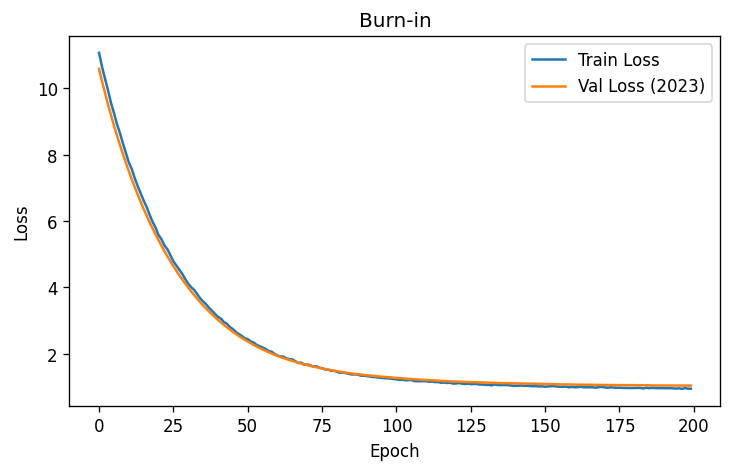


Baseline accuracy on 2023 (no weekly updates): 0.546



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

from keras.callbacks import Callback

class SaveBestAccuracy(Callback):
    def __init__(self):
        super().__init__()
        self.best_weights = None
        self.best_acc = 0

    def on_epoch_end(self, epoch, logs=None):
        current_acc = logs.get('val_accuracy')
        if current_acc > self.best_acc:
            self.best_acc = current_acc
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

# ─────────── Config ───────────
HALF_LIFE_DAYS   = 400.0     # weight‑decay half‑life
MIN_WEIGHT       = 0.05
ROLLING_DAYS     = 365       # history window for each update
EPOCHS_INIT      = 200       # burn‑in
EPOCHS_FINE      = 3         # tiny weekly update
BATCH_SIZE_INIT  = 32
BATCH_SIZE_FINE  = 8
USE_WEIGHTS      = False
FINE_LR          = 1e-4      # higher LR now that we keep optimiser state
MIN_WEEK_SAMPLES = 100       # skip weeks with too few past games

# 1) fit scaler on *all* numeric features
scaler = StandardScaler().fit(full_df[selected_columns])

# 2) build model
n_feats = len(selected_columns)
n_teams = max(full_df['home_id'].max(), full_df['away_id'].max()) + 1
model   = build_model(n_feats, n_teams=n_teams)

# 3) split into historical (2018‑22) and test‑year (2023)
mask_hist = full_df['game_date'].dt.year < 2023
mask_val  = full_df['game_date'].dt.year == 2023

X_hist = scaler.transform(full_df.loc[mask_hist, selected_columns])
h_hist = full_df.loc[mask_hist, 'home_id'].values
a_hist = full_df.loc[mask_hist, 'away_id'].values
y_hist = full_df.loc[mask_hist, 'outcome'].values

X_val  = scaler.transform(full_df.loc[mask_val, selected_columns])
h_val  = full_df.loc[mask_val,  'home_id'].values
a_val  = full_df.loc[mask_val,  'away_id'].values
y_val  = full_df.loc[mask_val,  'outcome'].values
X_all = np.vstack([X_hist, X_val])
h_all = np.concatenate([h_hist, h_val])
a_all = np.concatenate([a_hist, a_val])
y_all = np.concatenate([y_hist, y_val])

# 4) burn‑in on 2018‑22, validate on all 2023
print('>>> Burn‑in on 2018‑22 (val = all 2023)…')
es_init = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer=AdamW(learning_rate=FINE_LR, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_acc_callback = SaveBestAccuracy()
hist_init = model.fit(
    [X_hist, h_hist, a_hist], y_hist,
    validation_data = ([X_val, h_val, a_val], y_val),
    epochs          = EPOCHS_INIT,
    batch_size      = BATCH_SIZE_INIT,
    callbacks       = [best_acc_callback],
    verbose         = 1
)

# ── diagnostics
plt.figure(figsize=(7,4))
plt.plot(hist_init.history['loss'],     label='Train Loss')
plt.plot(hist_init.history['val_loss'], label='Val Loss (2023)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Burn‑in'); plt.legend(); plt.show()

_, base_acc = model.evaluate([X_val, h_val, a_val], y_val, verbose=0)
print(f'\nBaseline accuracy on 2023 (no weekly updates): {base_acc:.3f}\n')


probs_array = model.predict([X_val, h_val, a_val], verbose=0)

# 5) Assemble your back‑test DataFrame from the same 2023 mask
matches_df_bt = (
    full_df.loc[mask_val, ['odds_home_win','odds_draw','odds_away_win','outcome']]
    .reset_index(drop=True)
    .rename(columns={'outcome':'result'})
)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

from keras.callbacks import Callback

class SaveBestAccuracy(Callback):
    def __init__(self):
        super().__init__()
        self.best_weights = None
        self.best_acc = 0

    def on_epoch_end(self, epoch, logs=None):
        current_acc = logs.get('val_accuracy')
        if current_acc > self.best_acc:
            self.best_acc = current_acc
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)

# ─────────── Config ───────────
HALF_LIFE_DAYS   = 400.0     # weight‑decay half‑life
MIN_WEIGHT       = 0.05
ROLLING_DAYS     = 365       # history window for each update
EPOCHS_INIT      = 100       # burn‑in
EPOCHS_FINE      = 3         # tiny weekly update
BATCH_SIZE_INIT  = 32
BATCH_SIZE_FINE  = 8
USE_WEIGHTS      = False
FINE_LR          = 1e-4      # higher LR now that we keep optimiser state
MIN_WEEK_SAMPLES = 100       # skip weeks with too few past games

# 1) fit scaler on *all* numeric features
scaler = StandardScaler().fit(full_df[selected_columns])

# 2) build model
n_feats = len(selected_columns)
n_teams = max(full_df['home_id'].max(), full_df['away_id'].max()) + 1
model   = build_model(n_feats, n_teams=n_teams)

# 3) split into historical (2018‑22) and test‑year (2023)
mask_hist = full_df['game_date'].dt.year < 2023
mask_val  = full_df['game_date'].dt.year == 2023

X_hist = scaler.transform(full_df.loc[mask_hist, selected_columns])
h_hist = full_df.loc[mask_hist, 'home_id'].values
a_hist = full_df.loc[mask_hist, 'away_id'].values
y_hist = full_df.loc[mask_hist, 'outcome'].values

X_val  = scaler.transform(full_df.loc[mask_val, selected_columns])
h_val  = full_df.loc[mask_val,  'home_id'].values
a_val  = full_df.loc[mask_val,  'away_id'].values
y_val  = full_df.loc[mask_val,  'outcome'].values
X_all = np.vstack([X_hist, X_val])
h_all = np.concatenate([h_hist, h_val])
a_all = np.concatenate([a_hist, a_val])
y_all = np.concatenate([y_hist, y_val])

# 4) burn‑in on 2018‑22, validate on all 2023
print('>>> Burn‑in on 2018‑22 (val = all 2023)…')
es_init = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(
    optimizer=AdamW(learning_rate=FINE_LR, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
best_acc_callback = SaveBestAccuracy()
hist_init = model.fit(
    [X_all, h_all, a_all], y_all,
    validation_data = ([X_val, h_val, a_val], y_val),
    epochs          = EPOCHS_INIT,
    batch_size      = BATCH_SIZE_INIT,
    callbacks       = [best_acc_callback],
    verbose         = 1
)

# ── diagnostics
plt.figure(figsize=(7,4))
plt.plot(hist_init.history['loss'],     label='Train Loss')
plt.plot(hist_init.history['val_loss'], label='Val Loss (2023)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Burn‑in'); plt.legend(); plt.show()

_, base_acc = model.evaluate([X_val, h_val, a_val], y_val, verbose=0)
print(f'\nBaseline accuracy on 2023 (no weekly updates): {base_acc:.3f}\n')


probs_array = model.predict([X_test, h_test, a_test], verbose=0)

# 5) Assemble matches DataFrame for back‑testing
matches_df_bt = (
    full_df.loc[mask_test, ['odds_home_win','odds_draw','odds_away_win','outcome']]
    .reset_index(drop=True)
    .rename(columns={'outcome': 'result'})
)

# 5) prepare weekly index for 2023
val_df = full_df.loc[mask_val].copy()
val_df['iso_week'] = val_df['game_date'].dt.isocalendar().week
weeks = sorted(val_df['iso_week'].unique())

# ── freeze everything except team embedding + prediction layer ──────────
for layer in model.layers:
    layer.trainable = layer.name in {'team_emb', 'pred'}

train_losses, test_losses, week_accs = [], [], []
all_preds, all_truths = [], []

probs_chrono   = []
matches_chrono = []
processed_weeks = []

# 6) rolling‑window weekly fine‑tune
for wk in weeks:
    first_day = val_df.loc[val_df.iso_week == wk, 'game_date'].min()

    # rolling 365‑day window ending *day before* first match of the week
    win_df = val_df[(val_df.game_date < first_day) &
                    (val_df.game_date >= first_day - pd.Timedelta(days=ROLLING_DAYS))]

    if len(win_df) < MIN_WEEK_SAMPLES:
        print(f'Week {wk:>2}: {len(win_df)} samples < {MIN_WEEK_SAMPLES}, skipping')
        continue

    processed_weeks.append(wk)

    X_win = scaler.transform(win_df[selected_columns])
    h_win = win_df['home_id'].values
    a_win = win_df['away_id'].values
    y_win = win_df['outcome'].values

    # recency weights
    if USE_WEIGHTS:
        ages  = (first_day - win_df['game_date']).dt.days
        w_win = np.maximum(MIN_WEIGHT, 0.5 ** (ages / HALF_LIFE_DAYS))
    else:
        w_win = None

    # this week’s fixtures
    idxs  = val_df[val_df.iso_week == wk].index
    X_te  = scaler.transform(full_df.loc[idxs, selected_columns])
    h_te  = full_df.loc[idxs, 'home_id'].values
    a_te  = full_df.loc[idxs, 'away_id'].values
    y_te  = full_df.loc[idxs, 'outcome'].values

    print(f'\nWeek {wk:>2}: fine‑tune on {len(X_win)} samples')

    best_acc_fine = SaveBestAccuracy()
    hist = model.fit(
        [X_win, h_win, a_win], y_win,
        sample_weight   = w_win,
        validation_data = ([X_te, h_te, a_te], y_te),
        epochs          = EPOCHS_FINE,
        batch_size      = BATCH_SIZE_FINE,
        callbacks       = [best_acc_fine],
        verbose         = 0
    )

    # store metrics
    train_losses.append(hist.history['loss'][-1])
    test_losses .append(hist.history['val_loss'][-1])

    y_pred = np.argmax(model.predict([X_te, h_te, a_te], verbose=0), axis=1)
    wk_acc = (y_pred == y_te).mean()
    week_accs.append(wk_acc)
    print(f'  week accuracy = {wk_acc:.3f}')

    # save probabilities & matches for later back‑test
    probs_chrono  .append(model.predict([X_te, h_te, a_te], verbose=0))
    matches_chrono.append(full_df.loc[idxs, ['odds_home_win','odds_draw','odds_away_win','outcome']])

    all_preds .extend(y_pred.tolist())
    all_truths.extend(y_te.tolist())

# ── assemble chronologically ordered arrays for downstream back‑tests ───
probs_array   = np.vstack(probs_chrono)
matches_df_bt = pd.concat(matches_chrono, ignore_index=True).rename(columns={'outcome':'result'})

# 7) plot weekly loss + accuracy
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(processed_weeks, train_losses, marker='o', label='Train Loss')
ax1.plot(processed_weeks, test_losses , marker='o', label='Test Loss')
ax1.set_xlabel('ISO Week'); ax1.set_ylabel('Loss'); ax1.legend(loc='upper left')
ax2 = ax1.twinx(); ax2.set_ylabel('Week Accuracy')
ax2.plot(processed_weeks, week_accs, marker='s', color='tab:green', label='Acc')
ax2.legend(loc='upper right')
plt.title('Rolling Weekly Fine‑Tune (3 epochs, AdamW)'); plt.show()

# 8) final aggregated metrics
pred_lbl = np.array(all_preds)
truths   = np.array(all_truths)

print('\nOverall 2023 after weekly fine‑tune:')
print(f'  Acc  : {(pred_lbl == truths).mean():.3f}')
print(f'  Prec : {precision_score(truths, pred_lbl, average="macro"):.3f}')
print(f'  Rec  : {recall_score(truths, pred_lbl, average="macro"):.3f}')
print(f'  F1   : {f1_score(truths, pred_lbl, average="macro"):.3f}')


>>> Burn‑in on 2018‑22 (val = all 2023)…
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2767 - loss: 10.9967 - val_accuracy: 0.2816 - val_loss: 10.4121
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3079 - loss: 10.4431 - val_accuracy: 0.3010 - val_loss: 9.9129
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3090 - loss: 10.0174 - val_accuracy: 0.3131 - val_loss: 9.4601
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3411 - loss: 9.5481 - val_accuracy: 0.3544 - val_loss: 9.0354
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3562 - loss: 9.0964 - val_accuracy: 0.3738 - val_loss: 8.6336
Epoch 6/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3605 - loss: 8.7284 - val_accuracy: 0.4053 - val_loss: 8.2480
Epoch 7/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3787 - loss: 8.3095 - val_accuracy: 0.4248 - val_loss: 7.8876
Epoch 8/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3698 - loss: 7.9695 - val_accuracy: 0.4320 - val_loss

KeyboardInterrupt: 

In [ ]:
#Finding optimal model parameters

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
from keras import Input, Model
from keras.layers import Embedding, Flatten, Concatenate, Dense, BatchNormalization, LeakyReLU, Dropout
from keras.optimizers import Adam


X_train, h_train, a_train, y_train = X_hist, h_hist, a_hist, y_hist
X_val,   h_val,   a_val,   y_val   = X_val,   h_val,   a_val,   y_val

n_feats = X_train.shape[1]
n_teams = max(full_df['home_id'].max(),
              full_df['away_id'].max()) + 1

def build_model(n_feats: int,
                n_teams: int,
                emb_dim: int = 16,
                lr: float   = 1e-4,
                dense_units: list[int] = [160,256,32],
                drop_rates:  list[float] = [0.5,0.5,0.6],
               ):


    numeric_input = Input(shape=(n_feats,), name='numeric_input')
    home_input    = Input(shape=(1,),  dtype='int32', name='home_input')
    away_input    = Input(shape=(1,),  dtype='int32', name='away_input')

    # team embeddings
    team_emb = Embedding(input_dim=n_teams, output_dim=emb_dim, name='team_embedding')
    h = Flatten()(team_emb(home_input))
    a = Flatten()(team_emb(away_input))

    x = Concatenate(name='concat')([numeric_input, h, a])

    # three‐layer dense stack w/ BN, LeakyReLU, Dropout
    for units, dr in zip(dense_units, drop_rates):
        x = Dense(units, kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(negative_slope=0.1)(x)
        if dr > 0:
            x = Dropout(dr)(x)

    output = Dense(3, activation='softmax', name='predictions')(x)

    model = Model(
        inputs=[numeric_input, home_input, away_input],
        outputs=output,
        name='match_predictor'
    )
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# ─────────── The HyperModel wrapper ────────────────────────────
def model_builder(hp):
    emb_dim = hp.Int('emb_dim',  8, 64, step=8, default=16)
    lr      = hp.Float('lr',     1e-5,1e-3, sampling='log', default=1e-4)

    # tune each dense layer’s width
    d1 = hp.Int('dense1', 64, 256, step=32, default=160)
    d2 = hp.Int('dense2', 64, 256, step=32, default=256)
    d3 = hp.Int('dense3', 16, 128, step=16, default=32)

    # tune each layer’s dropout
    drop1 = hp.Float('drop1', 0.0, 0.6, step=0.1, default=0.5)
    drop2 = hp.Float('drop2', 0.0, 0.6, step=0.1, default=0.5)
    drop3 = hp.Float('drop3', 0.0, 0.6, step=0.1, default=0.6)

    return build_model(
        n_feats     = n_feats,
        n_teams     = n_teams,
        emb_dim     = emb_dim,
        lr          = lr,
        dense_units = [d1, d2, d3],
        drop_rates  = [drop1, drop2, drop3]
    )

# ─────────── Tuner setup & search ─────────────────────────────
tuner = kt.Hyperband(
    hypermodel   = model_builder,
    objective    = 'val_accuracy',
    max_epochs   = 40,
    factor       = 3,
    directory    = 'tuner_logs',
    project_name = 'soccer_arch_search2'
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    x = {
      'numeric_input': X_train,
      'home_input'   : h_train,
      'away_input'   : a_train
    },
    y               = y_train,
    validation_data = (
      {
        'numeric_input': X_val,
        'home_input'   : h_val,
        'away_input'   : a_val
      },
      y_val
    ),
    epochs    = 40,
    callbacks = [early_stop],
    verbose   = 1
)

# ─────────── Grab & evaluate best ─────────────────────────────
best_model = tuner.get_best_models(num_models=1)[0]
best_hp    = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
for k,v in best_hp.values.items():
    print(f"  {k}: {v}")

loss, acc = best_model.evaluate(
    {'numeric_input': X_val,
     'home_input'   : h_val,
     'away_input'   : a_val},
    y_val,
    verbose=0
)
print(f"Validation accuracy: {acc:.3f}")


Reloading Tuner from tuner_logs/soccer_arch_search2/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(126, 96), Received: value.shape=(124, 96). Target variable: <Variable path=dense/kernel, shape=(126, 96), dtype=float32, value=[[ 0.13936757 -0.01442023 -0.1804848  ...  0.0891753  -0.00823325
  -0.21293147]
 [-0.15882    -0.01382966 -0.1804915  ... -0.18503365  0.04759772
  -0.14258064]
 [ 0.02460298 -0.12775992  0.06369616 ... -0.08258891 -0.18204218
  -0.07137424]
 ...
 [ 0.10746734  0.17305313  0.08402564 ... -0.12297971  0.07464446
   0.17142792]
 [-0.19411162 -0.19315848  0.1771098  ...  0.02688964  0.09776248
   0.00344841]
 [ 0.03478475 -0.21251976  0.10093947 ...  0.0341454  -0.16971844
  -0.1807528 ]]>

List of objects that could not be loaded:
[<Dense name=dense, built=True>]

In [ ]:
# Predict on test set
X_test = scaler.transform(full_df_test[selected_columns])

# 2) pull out the home/away IDs
h_test = full_df_test['home_id'].values
a_test = full_df_test['away_id'].values

# (If you have true labels:)
y_test = full_df_test['outcome'].values
y_pred = model.predict(X_test)
print(y_pred[:10])

NameError: name 'full_df_test' is not defined

In [ ]:
import numpy as np

unique, counts = np.unique(y_val, return_counts=True)
dist = dict(zip(unique, counts))
print("Class counts:", dist)

# if you want percentages:
total = counts.sum()
pct  = counts / total
print("Class percentages:", dict(zip(unique, pct)))


Class counts: {np.int64(0): np.int64(201), np.int64(1): np.int64(86), np.int64(2): np.int64(125)}
Class percentages: {np.int64(0): np.float64(0.4878640776699029), np.int64(1): np.float64(0.2087378640776699), np.int64(2): np.float64(0.30339805825242716)}


## Model Evaluation
#### Strategy:
1. Calculate betting odds vs. our models prediction
2. Balance portfolio accordingly: higher stakes on greater difference and lower stakes in lesser differences

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Assuming you already have:
# y_pred - model predictions (probabilities for each class)
# y_test - true labels (one-hot encoded or class indices)

def plot_reliability_diagram(y_true, y_pred, n_bins=10, class_names=None):
    """
    Plot reliability diagram for a multi-class model.

    Parameters:
    y_true: One-hot encoded true labels or class indices
    y_pred: Predicted probabilities for each class
    n_bins: Number of bins to use in the diagram
    class_names: Names of the classes (optional)
    """
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_pred.shape[1])]

    # Convert one-hot encoded targets to class indices if needed
    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    fig, ax = plt.subplots(1, y_pred.shape[1], figsize=(15, 5))

    for i in range(y_pred.shape[1]):
        # For each class, create binary problem
        y_true_binary = (y_true == i).astype(int)
        y_pred_binary = y_pred[:, i]

        # Calculate calibration curve
        prob_true, prob_pred = calibration_curve(y_true_binary, y_pred_binary, n_bins=n_bins)

        # Calculate ECE for this class
        ece = expected_calibration_error(y_true_binary, y_pred_binary, n_bins=n_bins)

        # Calculate Brier score for this class
        brier = brier_score_loss(y_true_binary, y_pred_binary)

        # Plot calibration curve
        ax[i].plot(prob_pred, prob_true, marker='o', linewidth=1, label=f'Calibration curve')
        ax[i].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

        ax[i].set_title(f'{class_names[i]}\nECE: {ece:.3f}, Brier: {brier:.3f}')
        ax[i].set_xlabel('Predicted probability')
        ax[i].set_ylabel('True probability')
        ax[i].legend(loc='lower right')
        ax[i].grid(True)

    plt.tight_layout()
    return fig

def expected_calibration_error(y_true, y_pred, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE).

    Parameters:
    y_true: Binary true labels
    y_pred: Predicted probabilities
    n_bins: Number of bins to use

    Returns:
    ECE value
    """
    bin_indices = np.digitize(y_pred, np.linspace(0, 1, n_bins+1)) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins-1)

    bin_sums = np.bincount(bin_indices, weights=y_pred, minlength=n_bins)
    bin_true = np.bincount(bin_indices, weights=y_true, minlength=n_bins)
    bin_counts = np.bincount(bin_indices, minlength=n_bins)

    # Avoid division by zero
    nonzero_mask = bin_counts > 0

    if not np.any(nonzero_mask):
        return 0.0

    bin_avg_pred = np.zeros(n_bins)
    bin_avg_true = np.zeros(n_bins)

    bin_avg_pred[nonzero_mask] = bin_sums[nonzero_mask] / bin_counts[nonzero_mask]
    bin_avg_true[nonzero_mask] = bin_true[nonzero_mask] / bin_counts[nonzero_mask]

    # Calculate ECE
    ece = np.sum(np.abs(bin_avg_pred[nonzero_mask] - bin_avg_true[nonzero_mask]) *
                 (bin_counts[nonzero_mask] / np.sum(bin_counts[nonzero_mask])))

    return ece

# Example usage:
# Assuming y_test is your true labels (either one-hot encoded or class indices)
# and y_pred is your model prediction probabilities

class_names = ['Home Win', 'Draw', 'Away Win']
reliability_fig = plot_reliability_diagram(y_test, y_pred, class_names=class_names)
plt.show()

# Calculate overall Brier score (multiclass version)
def multiclass_brier_score(y_true, y_pred):
    """
    Calculate multiclass Brier score.

    Parameters:
    y_true: One-hot encoded true labels or class indices
    y_pred: Predicted probabilities for each class

    Returns:
    Multiclass Brier score
    """
    # Convert class indices to one-hot if needed
    if len(y_true.shape) == 1:
        n_classes = y_pred.shape[1]
        y_true_onehot = np.zeros((len(y_true), n_classes))
        y_true_onehot[np.arange(len(y_true)), y_true] = 1
    else:
        y_true_onehot = y_true

    return np.mean(np.sum((y_pred - y_true_onehot) ** 2, axis=1))

# Calculate and print multiclass Brier score
brier_score = multiclass_brier_score(y_test, y_pred)
print(f"Multiclass Brier Score: {brier_score:.4f}")

#score after temperature scaling
brier_score_scaled = multiclass_brier_score(y_test, y_pred_scaled)
print(f"Multiclass Brier Score after Temperature Scaling: {brier_score_scaled:.4f}")

IndexError: tuple index out of range

In [ ]:
# TODO
test_matches = match_data[match_data['Date'] > test_cutoff]

In [ ]:
test_matches.head()

,Date,HomeTeam,AwayTeam,FTR,odds_home_win,odds_draw,odds_away_win,result
1900,2023-08-11,Burnley FC,Manchester City FC,A,8.00,5.5,1.33,2
1901,2023-08-12,Arsenal FC,Nottingham Forest FC,H,1.18,7.0,15.00,0
1902,2023-08-12,AFC Bournemouth,West Ham United FC,D,2.70,3.4,2.55,1
1903,2023-08-12,Brighton & Hove Albion FC,Luton Town FC,H,1.33,5.5,9.00,0
1904,2023-08-12,Everton FC,Fulham FC,A,2.20,3.4,3.30,2


In [ ]:
def evaluate_model_performance(y_pred, y_test):
    """
    Calculate and display classification metrics for the model

    Args:
        y_pred: Predicted probabilities from the model
        y_test: Actual match results (0=Home, 1=Draw, 2=Away)
    """
    # Convert probabilistic predictions to class predictions
    y_pred_class = np.argmax(y_pred, axis=1)

    # Convert y_test to proper format if needed
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_class = np.argmax(y_test, axis=1)
    else:
        y_test_class = y_test

    # Calculate overall accuracy
    accuracy = np.mean(y_pred_class == y_test_class)

    # Calculate metrics for each class
    classes = ['Home', 'Draw', 'Away']
    metrics_by_class = {}

    for i, class_name in enumerate(classes):
        # True positives, false positives, false negatives
        true_pos = np.sum((y_pred_class == i) & (y_test_class == i))
        false_pos = np.sum((y_pred_class == i) & (y_test_class != i))
        false_neg = np.sum((y_pred_class != i) & (y_test_class == i))
        true_neg = np.sum((y_pred_class != i) & (y_test_class != i))

        # Calculate metrics
        precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
        recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        metrics_by_class[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': np.sum(y_test_class == i)
        }

    # Display metrics
    print("\n===== MODEL PERFORMANCE METRICS =====")
    print(f"Overall Accuracy: {accuracy:.4f}")

    print("\nMetrics by Outcome:")
    print(f"{'Class':<10} {'Precision':<12} {'Recall':<12} {'F1 Score':<12} {'Support':<10}")
    print("-" * 58)

    for cls, metrics in metrics_by_class.items():
        print(f"{cls:<10} {metrics['precision']:<12.4f} {metrics['recall']:<12.4f} {metrics['f1']:<12.4f} {metrics['support']:<10}")

    # Calculate confusion matrix
    conf_matrix = np.zeros((3, 3), dtype=int)
    for i in range(3):
        for j in range(3):
            conf_matrix[i, j] = np.sum((y_test_class == i) & (y_pred_class == j))

    print("\nConfusion Matrix:")
    print(f"{'Actual/Pred':<12} {'Home':<8} {'Draw':<8} {'Away':<8}")
    print("-" * 40)
    for i, cls in enumerate(classes):
        print(f"{cls:<12} {conf_matrix[i, 0]:<8} {conf_matrix[i, 1]:<8} {conf_matrix[i, 2]:<8}")

    return accuracy, metrics_by_class, conf_matrix

# Get model predictions
y_pred = model.predict(X_test)

# Get actual outcomes from test_matches
y_test = test_matches['result'].values

# Evaluate model performance
evaluate_model_performance(y_pred, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

===== MODEL PERFORMANCE METRICS =====
Overall Accuracy: 0.5526

Metrics by Outcome:
Class      Precision    Recall       F1 Score     Support   
----------------------------------------------------------
Home       0.5471       0.8629       0.6696       175       
Draw       0.5000       0.0244       0.0465       82        
Away       0.5700       0.4634       0.5112       123       

Confusion Matrix:
Actual/Pred  Home     Draw     Away    
----------------------------------------
Home         151      2        22      
Draw         59       2        21      
Away         66       0        57      


(np.float64(0.5526315789473685),
 {'Home': {'precision': np.float64(0.5471014492753623),
   'recall': np.float64(0.8628571428571429),
   'f1': np.float64(0.6696230598669622),
   'support': np.int64(175)},
  'Draw': {'precision': np.float64(0.5),
   'recall': np.float64(0.024390243902439025),
   'f1': np.float64(0.046511627906976744),
   'support': np.int64(82)},
  'Away': {'precision': np.float64(0.57),
   'recall': np.float64(0.4634146341463415),
   'f1': np.float64(0.5112107623318386),
   'support': np.int64(123)}},
 array([[151,   2,  22],
        [ 59,   2,  21],
        [ 66,   0,  57]]))

## Testing Results
1. For each match we return a prediction value $p \in [0,1]$. If $0.4 < p < 0.7$ we discard the result and go to the next match. Otherwise continue to step 2
2. We calculate our betting odds from our prediction where $odd = \frac{1}{p}$. We calculate this for the home team winning, as well as for a draw or the away team winning.
3. If our odds are lower than the sportsbook's odds, we place a trade on the direction that our model predicts. If we predicted a home win, we place 100 on that stake. If we predicted a home team loss/draw, we split 50 on an away win and 50 on a draw

In [ ]:
def fair_draw_lose_allocation(game_data, book_odds):
  prediction = model.predict(game_data.reshape(1, -1), verbose=0)[0][0]

  # Alternative scheme that weighs away win and draw odds accordingly
  home_win = 1/(1 - prediction)
  away_win = 1/prediction

  if home_win < book_odds[0] and prediction < 0.3:
    return (0.1, 0, 0)

  elif away_win < book_odds[2] + book_odds[1] and prediction > 0.8:
    total = book_odds[2] + book_odds[1]

    return (0, (1 - book_odds[1]/total) * 0.1, (1 - book_odds[2]/total) * 0.1)

  else:
    return (0, 0, 0)

# **Risk Management**

The research paper's approach incorporates **Kelly Criterion** and **Sharpe Ratio Optimization** keeping portfolio structured efficiently based on *predicted probabilities* and *market odds*.

## **1. Portfolio Sizing and Capital Allocation**
- **Fractional betting approach** to mitigate risk. Instead of wagering the entire bankroll on each trade, a fraction of the Kelly Criterion output is used to control volatility.
- Based on simulations and historical backtesting in the research paper, an ideal **fractional Kelly at 17%** is applied to balance risk and return, preventing over-exposure to individual bets.
- The allocation for each trade is calculated using:

$l^* = \frac{p(o - 1) - (1 - p)}{o - 1}$

where $p$ is the model's probability prediction, and $o$ is the bookmaker's odds.

## **2. Bet Filtering to Reduce Variance**
- Predictions with **uncertainty between 0.4 and 0.7** are discarded to avoid high-variance bets where the model lacks confidence.
- Only matches with **clear probability deviations from bookmaker odds** are considered, ensuring positive expected value trades.
- This approach prevents unnecessary exposure to random noise in the model’s predictions.

## **3. Diversification Across Bets**
- Instead of placing all bets on a single outcome, we distribute wagers based on *expected value*.
- If the model predicts a **home win**, we allocate **100% of the bet** to that event.
- If the model predicts a **loss or draw**, we split the stake **50/50 between an away win and a draw** to hedge against misclassification.

## **4. Risk of Ruin and Capital Preservation**
- To avoid **bankroll depletion**, we implement:
  - **A maximum exposure limit per bet** (ensuring no more than 1-5% of total capital is risked on any single game).
  - **Stop-loss mechanisms**: If cumulative losses exceed a threshold, betting is paused to reassess model performance.
  - **Profit reinvestment strategies**: Instead of compounding 100% of profits, a portion is withdrawn to reduce downside risk.

## **5. Performance Evaluation and Adjustments**
- The portfolio is continuously evaluated using key metrics:
  - **Sharpe Ratio** to assess risk-adjusted returns.
  - **Log-Growth Rate** to measure compounding efficiency.
  - **Drawdown Analysis** to quantify worst-case scenarios.
- If negative performance trends emerge, hyperparameters are adjusted, or betting thresholds are tightened.

## **6. Simulation-Based Validation**
- Before deployment, strategies are tested via **Monte Carlo simulations** and **historical backtesting** to estimate potential outcomes under varying market conditions.
- By analyzing **simulated wealth curves**, the model's probability calibration and bet sizing effectiveness are refined before real capital is deployed.

In [ ]:
# 1) Select only 2023 matches
mask_2023 = full_df['game_date'].dt.year == 2023
val_df    = full_df.loc[mask_2023].copy()

# 2) Make sure your outcome column is named "result" (0=Home, 1=Draw, 2=Away)
#    If your column is called "outcome", rename it:
val_df = val_df.rename(columns={'outcome':'result'})

# 3) Pick only the columns your back‑tester needs
test_matches = (
    val_df[[
        'game_date',        # for printing/logging
        'HomeTeam',         # for printing/logging
        'AwayTeam',         # for printing/logging
        'odds_home_win',
        'odds_draw',
        'odds_away_win',
        'result'
    ]]
    .reset_index(drop=True)
)



Match 0: 2023-01-01 00:00:00 Tottenham Hotspur FC vs Aston Villa FC
  Probs:  H 0.653, D 0.203, A 0.144
  Odds :  H 1.67, D 4.00, A 5.00
  Kelly f: H 0.0200, D 0.0000, A 0.0000
  >> Staked: H $2000.00, D $0.00, A $0.00
  XX NO WIN: -$2000.00
  Trades this match: 1

Match 1: 2023-01-01 00:00:00 Nottingham Forest FC vs Chelsea FC
  Probs:  H 0.294, D 0.263, A 0.443
  Odds :  H 5.00, D 3.80, A 1.70
  Kelly f: H 0.0200, D 0.0000, A 0.0000
  >> Staked: H $1960.00, D $0.00, A $0.00
  XX NO WIN: -$1960.00
  Trades this match: 1

Match 2: 2023-01-02 00:00:00 Brentford FC vs Liverpool FC
  Probs:  H 0.239, D 0.245, A 0.516
  Odds :  H 5.50, D 4.33, A 1.55
  Kelly f: H 0.0157, D 0.0043, A 0.0000
  >> Staked: H $1512.06, D $408.74, A $0.00
  !! WIN on Home: +$6804.25
  Trades this match: 2

Match 3: 2023-01-03 00:00:00 Everton FC vs Brighton & Hove Albion FC
  Probs:  H 0.323, D 0.262, A 0.416
  Odds :  H 3.50, D 3.50, A 2.10
  Kelly f: H 0.0200, D 0.0000, A 0.0000
  >> Staked: H $2048.71, D $0.

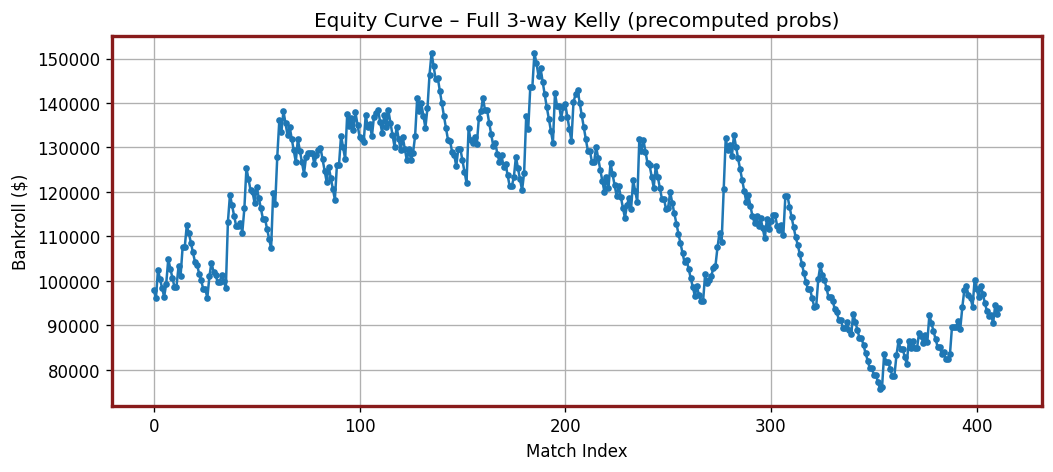

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np

def full_kelly_allocation(p: np.ndarray,
                          odds: np.ndarray,
                          cap: float = 0.02) -> np.ndarray:
    """
    Compute 3‑way Kelly fractions for each outcome.

    - p:   array([p_home, p_draw, p_away])
    - odds: array([o_home, o_draw, o_away])  (decimal odds, e.g. 2.50)
    - cap: maximum total fraction of bankroll to bet

    Returns f: array([f_home, f_draw, f_away]) summing to ≤ cap.
    """
    # net odds (b) = decimal_odds − 1
    b = odds - 1.0
    # avoid division by zero if any odds == 1
    safe = b > 0
    f_raw = np.zeros_like(p, dtype=float)

    # Kelly formula: f = (p*(b+1) - 1) / b  ==  (b*p - (1-p)) / b
    f_raw[safe] = (p[safe] * odds[safe] - 1.0) / b[safe]
    # floor negatives
    f_raw = np.maximum(0.0, f_raw)

    total = f_raw.sum()
    if total > cap and total > 0:
        # scale all fractions so sum == cap
        f = f_raw * (cap / total)
    else:
        f = f_raw

    return f


def run_backtest_full_kelly_with_probs(bankroll_start: float,
                                       probs: np.ndarray,
                                       test_matches: pd.DataFrame,
                                       cap: float = 0.02):
    """
    Backtest using full 3-way Kelly allocation with precomputed probability vectors.
    - bankroll_start: initial bankroll
    - probs: array of shape (n_matches, 3) with [p_home, p_draw, p_away]
    - test_matches: DataFrame with columns ['Date','HomeTeam','AwayTeam',
      'odds_home_win','odds_draw','odds_away_win','result']
    - cap: maximum total fraction to stake
    """
    bankroll = bankroll_start
    equity_curve = []
    total_trades = total_wins = 0

    n = min(len(probs), len(test_matches))
    for i in range(n):
        p_vec = probs[i]
        match = test_matches.iloc[i]
        odds = np.array([
            match['odds_home_win'],
            match['odds_draw'],
            match['odds_away_win']
        ], dtype=float)

        f = full_kelly_allocation(p_vec, odds, cap=cap)

        print(f"\nMatch {i}: {match['game_date']} {match['HomeTeam']} vs {match['AwayTeam']}")
        print(f"  Probs:  H {p_vec[0]:.3f}, D {p_vec[1]:.3f}, A {p_vec[2]:.3f}")
        print(f"  Odds :  H {odds[0]:.2f}, D {odds[1]:.2f}, A {odds[2]:.2f}")
        print(f"  Kelly f: H {f[0]:.4f}, D {f[1]:.4f}, A {f[2]:.4f}")

        if f.sum() == 0:
            print("  >> SKIP (no edges large enough)")
            equity_curve.append(bankroll)
            continue

        stake = f * bankroll
        bankroll -= stake.sum()
        print(f"  >> Staked: H ${stake[0]:.2f}, D ${stake[1]:.2f}, A ${stake[2]:.2f}")

        result = int(match['result'])
        if stake[result] > 0:
            payout = stake[result] * odds[result]
            profit = payout - stake[result]
            bankroll += payout
            total_wins += 1
            print(f"  !! WIN on {['Home','Draw','Away'][result]}: +${profit:.2f}")
        else:
            loss = stake.sum()
            print(f"  XX NO WIN: -${loss:.2f}")

        trades_this = np.count_nonzero(stake)
        total_trades += trades_this
        print(f"  Trades this match: {trades_this}")
        equity_curve.append(bankroll)

    print(f"\nTOTAL TRADES: {total_trades}, TOTAL WINS: {total_wins}")
    print(f"FINAL BANKROLL: ${bankroll:.2f}")

    fig, ax = plt.subplots(figsize=(10, 4))

    # 2) Plot on the ax
    ax.plot(equity_curve, marker='o', markersize=3)

    # 3) Labels & grid
    ax.set_title("Equity Curve – Full 3-way Kelly (precomputed probs)")
    ax.set_xlabel("Match Index")
    ax.set_ylabel("Bankroll ($)")
    ax.grid(True)

    # 4) Style the four spines
    for spine in ax.spines.values():
        spine.set_edgecolor('#881b1b')
        spine.set_linewidth(2)

    plt.show()

    return equity_curve

# Example usage, assuming `probs_array` and `test_matches` are defined:
equity = run_backtest_full_kelly_with_probs(100000, probs_array, test_matches, cap=0.02)


In [ ]:
print(test_matches.columns)

Index(['game_date', 'HomeTeam', 'AwayTeam', 'odds_home_win', 'odds_draw',
       'odds_away_win', 'result'],
      dtype='object')


Trades: 133  |  Wins: 42
Final bankroll: $108,695.79  (Start 100,000.00)


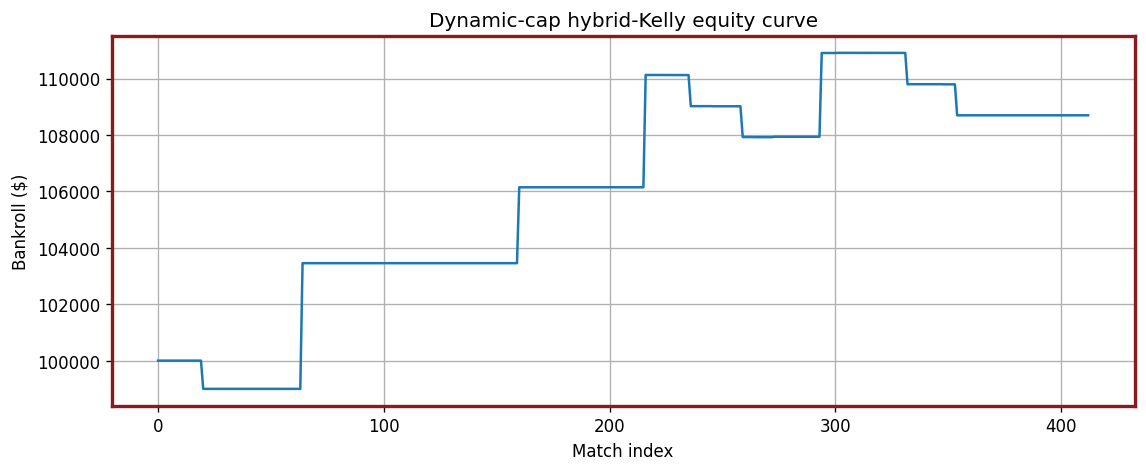

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ──────────────────────────────────────────────────────────────
# 1) Tail-aware fractional-Kelly allocation
# ──────────────────────────────────────────────────────────────
def hybrid_kelly_allocation(probs: np.ndarray,
                            odds : np.ndarray,
                            cap  : float = 0.02,
                            fixed_frac : float = 0.01,
                            min_edge   : float = 0.05,
                            kelly_top_pct : float = 0.10,
                            cvar_alpha : float = 0.10,
                            cvar_lambda: float = 2.0,
                            frac_kelly : float = 0.50) -> np.ndarray:
    """
    •  Fixed fraction 'fixed_frac' on every leg with edge >= min_edge.
    •  For the top kelly_top_pct positive-edge legs, solve a Kelly problem
       with a CVaR penalty:  maximize E[log(1+fR)] − λ·CVaR_α(−fR)
       then use `frac_kelly` of that solution.
    •  Cap total stake at 'cap'.
    """
    p = np.asarray(probs, dtype=float).flatten()
    o = np.asarray(odds , dtype=float).flatten()
    edges = p - 1/o

    f = np.zeros_like(p)

    # ── 1) fixed 1 % stake on every decent edge ───────────────────────────
    f[edges >= min_edge] = fixed_frac

    # ── 2) pick top-X % positive edges for Kelly optimisation ─────────────
    pos_mask = edges > 0
    if np.any(pos_mask):
        # get threshold for top kelly_top_pct of positive edges
        kth = np.quantile(edges[pos_mask], 1 - kelly_top_pct)
        kelly_mask = edges >= max(kth, min_edge)

        if kelly_mask.sum() > 0:

            # build objective with CVaR penalty ----------------------------
            p_k  = p[kelly_mask]
            o_k  = o[kelly_mask]
            nleg = kelly_mask.sum()

            # simulate 2-state return per leg:  win => (O-1),  lose => -1
            win_ret  = (o_k - 1)
            lose_ret = -np.ones_like(o_k)

            def cvar_objective(f_vec):
                """
                f_vec length = nleg
                Returns negative (to be minimised) of:
                    E[log(1+fR)] - λ CVaR_α(-fR)
                """
                f_vec = np.clip(f_vec, 0, cap)  # safety

                # expected log-growth
                g_win  = np.log1p(f_vec * win_ret)
                g_lose = np.log1p(f_vec * lose_ret)
                exp_log = (p_k * g_win + (1 - p_k) * g_lose).sum()

                # portfolio return distribution (two-point)
                ret_plus  = (f_vec * win_ret).sum()   # with prob prod p_k (not exact)
                ret_minus = (f_vec * lose_ret).sum()  # with prob prod (1-p_k)
                # simple two-point CVaR at alpha
                worst = min(ret_plus, ret_minus)
                cvar  = -worst / cvar_alpha           # crude for 2-point dist

                return -(exp_log - cvar_lambda * cvar)

            # constraints: sum f <= cap
            cons   = ({'type':'ineq', 'fun':lambda f_vec: cap - f_vec.sum()},)
            bounds = [(0, cap)] * nleg
            x0     = np.full(nleg, cap / nleg)

            res = minimize(cvar_objective, x0, method='SLSQP',
                           bounds=bounds, constraints=cons)

            if res.success:
                f_kelly = frac_kelly * res.x
                f[kelly_mask] = f_kelly

    # ── 3) final rescale if total > cap ───────────────────────────────────
    tot = f.sum()
    if tot > cap and tot > 0:
        f *= cap / tot
    return f


# ──────────────────────────────────────────────────────────────
# 2) Back-tester with dynamic cap
# ──────────────────────────────────────────────────────────────
def run_backtest_with_probs(bankroll_start : float,
                            probs        : np.ndarray,   # <─ NEW
                            matches_df   : pd.DataFrame,
                            base_cap      : float = 0.02,
                            vol_lookback  : int   = 20,
                            vol_factor    : float = 0.01,
                            **alloc_kw):
    """
    Dynamic‑cap hybrid‑Kelly back‑test that uses a supplied `probs`
    array (n_matches × 3) aligned with `matches_df`.
    """
    bankroll = bankroll_start
    equity   = [bankroll]
    trades = wins = 0

    n = min(len(probs), len(matches_df))
    for i in range(n):
        # ── dynamic cap based on recent equity moves ───────────────
        if i >= vol_lookback:
            recent = np.diff(equity[-vol_lookback:])
            rolling_std = np.std(recent) if recent.std() > 0 else 1e-6
            dyn_cap = min(base_cap, vol_factor / rolling_std)
        else:
            dyn_cap = base_cap

        p_vec = probs[i]                               # <<— use given probs
        match = matches_df.iloc[i]
        odds  = match[['odds_home_win',
                       'odds_draw',
                       'odds_away_win']].values.astype(float)

        f = hybrid_kelly_allocation(p_vec, odds, cap=dyn_cap, **alloc_kw)

        stake = f * bankroll
        bankroll -= stake.sum()

        result = int(match['result'])                  # 0,1,2
        if stake[result] > 0:
            bankroll += stake[result] * odds[result]
            wins += 1
        trades += np.count_nonzero(stake)
        equity.append(bankroll)

    # ── summary & plot ────────────────────────────────────────────
    print(f"Trades: {trades}  |  Wins: {wins}")
    print(f"Final bankroll: ${bankroll:,.2f}  (Start {bankroll_start:,.2f})")


    fig, ax = plt.subplots(figsize=(11, 4))

    ax.plot(equity)
    ax.set_title("Dynamic‑cap hybrid‑Kelly equity curve")
    ax.set_xlabel("Match index")
    ax.set_ylabel("Bankroll ($)")
    ax.grid(True)

    # Color and thicken the four spines around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('#881b1b')
        spine.set_linewidth(2)

    plt.show()

    return equity


equity = run_backtest_with_probs(
    bankroll_start = 100_000,
    probs          = probs_array,      # ← stacked n×3 array
    matches_df     = matches_df_bt,    # ← odds+result DataFrame
    base_cap       = 0.02,
    vol_lookback   = 20,
    vol_factor     = 0.01,
    fixed_frac     = 0.01,
    min_edge       = 0.05,
    kelly_top_pct  = 0.10,
    frac_kelly     = 0.50,
    cvar_alpha     = 0.10,
    cvar_lambda    = 2.0
)